# Ground State of a Molecule
In this lab, we will calculate the ground state of a simple molecule and find the optimized interatomic distance between atoms.  We will also examine the performance of several different variational optimizers and find the ground state of a given, non-chemical Hamiltonian.

# Preparing  and Transforming the Molecular Hamiltonian Operator

To get us started with finding the ground state of a molecule, we should *first* examine how we wish to characterize the Hamiltonian of our molecule.  The main problem with accurately simulating molecules is that the true Hamiltonian is an $N$-body problem which is quite difficult to deal with.  Instead, the common canonical approach is simplify the system into $N$ one-body problems where each electron responds to the mean-field of all the others.  This approach is known as the Hartree-Fock method and has a Hamiltonian written in the form:

$$
    H = \sum_{ij} h_{ij}\hat{c}_i^\dagger\hat{c}_j + \frac{1}{2}\sum_{ijkl} h_{ijkl} \hat{c}_i^\dagger\hat{c}_j^\dagger\hat{c}_k\hat{c}_l 
$$

where the creation ($\hat{c}_i^\dagger$) and annihilation ($\hat{c}_i$) operators act on a basis of molecular orbitals electrons are able to occupy ($\phi_i$).  Each of these orbitals can be occupied or unoccupied with a single electron of a given spin.  The parameters $h_{ij}$ and $h_{ijkl}$ store the one-body and two body integrals of the molecular orbital basis functions

$$
    h_{ij} = \int \phi_i^*(r)\left(-\frac{1}{2}\nabla^2 - \sum_I \frac{Z_I}{R_I-r} \right)\phi_i(r) dr \\ \\
    h_{ijkl} = \int \frac{\phi_i^*(r_1)\phi_j^*(r_2)\phi_k(r_1)\phi_l(r_2)}{|r_1-r_2|}dr_1dr_2
$$
where the values $Z_I$ and $R_I$ are the charge and position of each of the atomic nuclei in the molecule.

Luckily, computational chemists have developed libraries which can calculate these integrals for us so we don't have to!  Qiskit accesses these libraries through what are called *drivers*.  In the code below we will initialize an $H_2$ molecule at the ideal interatomic distance.

In [38]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
import qiskit_nature as qk_nature
qk_nature.settings.dict_aux_operators = True


#Initalize the driver for the H2 molecule.  The input for this are the element symbol as string followed by
# an array of x, y, z positions in units of angstroms.
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]])


driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYQUANTE)


#This prepares the second quantized fermionic operator after computing the one and two body orbitals
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()

print("Items of the second_q_op dict: \n")
for key, val in second_q_op.items():
    print(key,':', val, '\n')

Items of the second_q_op dict: 

ElectronicEnergy : Fermionic Operator
register length=4, number terms=14
  (0.18093120148374142+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093120148374134+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093120148374134+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093120148374128+0j) * ( -_0 +_1 -_2 +_3  ... 

ParticleNumber : Fermionic Operator
register length=4, number terms=4
  (1+0j) * ( +_0 -_0 )
+ (1+0j) * ( +_1 -_1 )
+ (1+0j) * ( +_2 -_2 )
+ (1+0j) * ( +_3 -_3 ) 

AngularMomentum : Fermionic Operator
register length=4, number terms=12
  (1+0j) * ( +_0 -_1 -_2 +_3 )
+ (1+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.75+0j) * ( +_3 -_3 )
+ (0.75+0j) * ( +_2 -_2 )
+ (0.5+0j) * ( +_2 -_2 +_3 -_3 )
+ (0.75+0j) * ( +_1 -_1 )
+ (-1.5+0j) * ( +_1 -_1 ... 

Magnetization : Fermionic Operator
register length=4, number terms=4
  (0.5+0j) * ( +_0 -_0 )
+ (0.5+0j) * ( +_1 -_1 )
+ (-0.5+0j) * ( +_2 -_2 )
+ (-0.5+0j) * ( +_3 -_3 ) 



## Transform Fermionic Operators to Pauli Operators

Great!  Now we have computed the second quantized hamiltonian of $H_2$ written in the molecular orbital basis (the `ElectronicEnergy` operator is what we're after).  However, this is written in terms of fermionic operators which cannot be encoded onto the operators of a quantum computer.  In order to encode this Hamiltonian to a quantum computing environment, the operators need to be mapped to spin (Pauli) operators.
![image1](./images/jw_mapping.png)
There exist many different mappings between fermionic and spin operators, each with their own properties, but the canonical (read: most popular as far as I know) transformation (and one that Qiskit already has support for) is the Jordan-Wigner transformation.  This transformation will map each molecular orbital to an individual qubit, thereby mapping the occupied and unnoccupied orbital state to the $|0\rangle$ and $|1\rangle$ state respectively.  The code below will take our second quantized Hamiltonian and write it in terms of Pauli operators.

In [39]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper


qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
H2_op = qubit_converter.convert(second_q_op['ElectronicEnergy'])
print(H2_op)

0.045232800370935335 * YYYY
+ 0.045232800370935335 * XXYY
+ 0.045232800370935335 * YYXX
+ 0.045232800370935335 * XXXX
- 0.8105479965981814 * IIII
- 0.22575350027942775 * ZIII
+ 0.17218394351950977 * IZII
+ 0.12091263344524698 * ZZII
- 0.22575350027942775 * IIZI
+ 0.17464343496146983 * ZIZI
+ 0.16614543381618233 * IZZI
+ 0.1721839435195099 * IIIZ
+ 0.16614543381618233 * ZIIZ
+ 0.1689275406336891 * IZIZ
+ 0.12091263344524698 * IIZZ


In this particular basis (STO-3G), 4 qubits are required to capture all the orbitals.  However, this can be reduced by taking advantage of parity operations using the `ParityMapper()` instead of the `JordanWignerMapper()` which reduces the number of qubits required to two.

In [40]:
from qiskit_nature.mappers.second_quantization import ParityMapper


qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
H2_op = qubit_converter.convert(second_q_op['ElectronicEnergy'], num_particles=es_problem.num_particles)
print(H2_op)

0.18093120148374128 * XX
- 1.052373263488675 * II
- 0.39793744379893736 * ZI
+ 0.39793744379893753 * IZ
- 0.011280107962794217 * ZZ


Now the Hamiltonian for the $H_2$ molecule is ready!  The next step is to send this operator to the VQE

## Running VQE

Recall in the previous notebook that the VQE algorithm consists of two pieces, the **variational form** (the structure of the variational circuit) and the **optimization algorithm** (which control how the parameters evolve).  Now that we have the operator we want to run, we are going to specify both of these and run them using the Aer simulator.  For this case we'll use the `SPSA` optimizer and the `EfficientSU2` ansatz with linear entanglement.

In [41]:

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.circuit.library import EfficientSU2


#Creating a QuantumInstance object will create an environment with the same starting seeds,
# ensuring that the resulting measurement data from the Aer simulator is the same everytime.  You do
# not have to do this for the lab, you can just set quantum_instance=backend.

seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)



counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


    
ansatz = EfficientSU2(num_qubits=4, entanglement='linear')
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)



result = vqe.compute_minimum_eigenvalue(operator=H2_op)

Text(0.5, 1.0, 'Convergence with no noise')

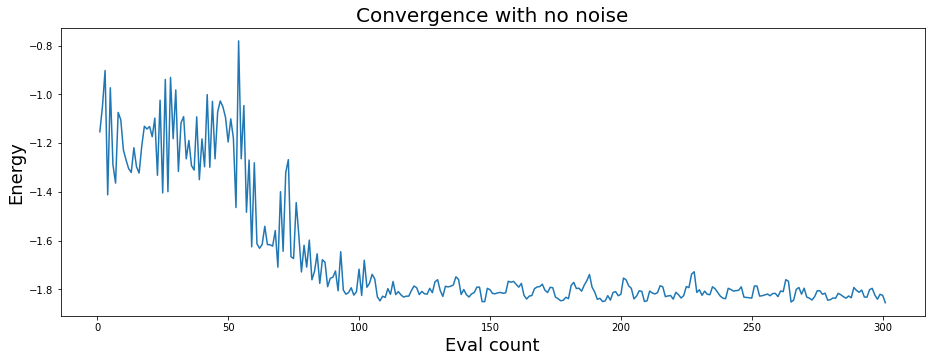

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
ax = fig.add_axes([1,1,1,1])
ax.plot(counts, values)
ax.set_xlabel('Eval count', size=18)
ax.set_ylabel('Energy', size=18)
ax.set_title('Convergence with no noise', size=20)

We'll also calculate the exact ground state energy for our `H2_op` variable and compare to what the VQE algorithm returned

In [43]:
npme = NumPyMinimumEigensolver()
result_npme = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result_npme.eigenvalue.real
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')


VQE on Aer qasm simulator (no noise): -1.85509
Delta from reference energy value is 0.00219


# &#128211; Compare the Performance of Variational Forms and Optimization Algorithms

## &#128211; Run the COBYLA, SLSQP, L_BFGS_B for the Linear and Fully entangled ansatz circuit to find the ground state of H2

### &#128211; Plot the energy against each step of the optimization.  Put all of this data in one or two plots to make the comparison easier to see.  

Feel free to read more about these optimizers [L_BFGS_B](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.L_BFGS_B.html?highlight=bfgs#qiskit.algorithms.optimizers.L_BFGS_B), [SLSQP](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SLSQP.html?highlight=slsqp#qiskit.algorithms.optimizers.SLSQP), [COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html?highlight=cobyla#qiskit.algorithms.optimizers.COBYLA)

## Linear Entanglement

### COBYLA

In [8]:
#You'll need to import the COBYLA, SLSQP, and L_BFGS_B optimizers the same way for SPSA above.  When 
#  initialized as a variable, you can set (among other things) the max number of iterations.  The default is 1000
#  and you may want to use a smaller amount when testing out your code.
#
#
# Your code goes here
#
#
from qiskit.algorithms.optimizers import COBYLA, SLSQP, L_BFGS_B

seed = 170
iterations = 300
algorithm_globals.random_seed = seed

backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)



counts_cobyla = []
values_cobyla = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts_cobyla.append(eval_count)
    values_cobyla.append(mean)


    
ansatz_linear_cobyla = EfficientSU2(num_qubits=4, entanglement='linear')
cobyla = COBYLA(maxiter=iterations)

vqe_linear_cobyla = VQE(ansatz_linear_cobyla, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=qi)



result_linear_cobyla = vqe_linear_cobyla.compute_minimum_eigenvalue(operator=H2_op)

### SLSQP

In [9]:
seed = 170
iterations = 300
algorithm_globals.random_seed = seed

backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)



counts_slsqp = []
values_slsqp = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts_slsqp.append(eval_count)
    values_slsqp.append(mean)


    
ansatz_linear_slsqp = EfficientSU2(num_qubits=4, entanglement='linear')
slsqp = SLSQP(maxiter=iterations)

vqe_linear_slsqp = VQE(ansatz_linear_slsqp, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)



result_linear_slsqp = vqe_linear_slsqp.compute_minimum_eigenvalue(operator=H2_op)

### L_BFGS_B

In [10]:
seed = 170
iterations = 300
algorithm_globals.random_seed = seed

backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)



counts_lbfgsb = []
values_lbfgsb = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts_lbfgsb.append(eval_count)
    values_lbfgsb.append(mean)


    
ansatz_linear_lbfgsb = EfficientSU2(num_qubits=4, entanglement='linear')
lbfgsb = L_BFGS_B(maxiter=iterations)

vqe_linear_lbfgsb = VQE(ansatz_linear_lbfgsb, optimizer=lbfgsb, callback=store_intermediate_result, quantum_instance=qi)



result_linear_lbfgsb = vqe_linear_lbfgsb.compute_minimum_eigenvalue(operator=H2_op)

### Plotting energy against optimization steps

Text(0.5, 1.0, 'Convergence with no noise')

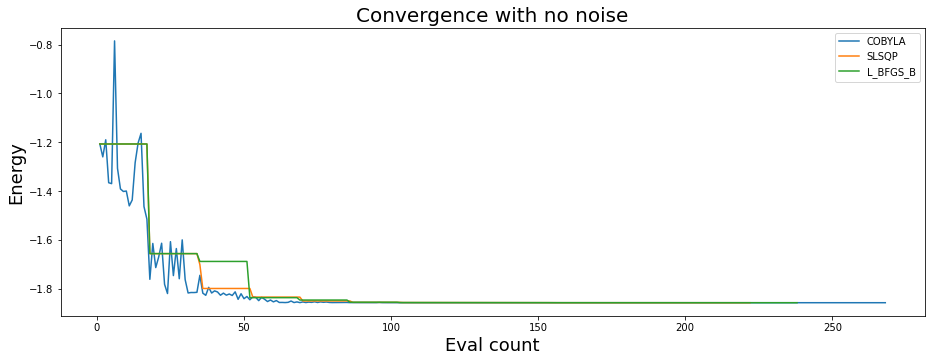

In [11]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_axes([1,1,1,1])

ax.plot(counts_cobyla, values_cobyla,label='COBYLA')
ax.plot(counts_slsqp, values_slsqp,label='SLSQP')
ax.plot(counts_lbfgsb, values_lbfgsb,label='L_BFGS_B')

ax.set_xlabel('Eval count', size=18)
ax.set_ylabel('Energy', size=18)
ax.legend()
#ax.set_xlim([0,100])

ax.set_title('Convergence with no noise', size=20)

In [12]:
import numpy as np

#Calculating the differences between the reference value and the ground state energies from different optimizers.
cobyla_ref = np.abs(values_cobyla[-1]-ref_value)
slsqp_ref = np.abs(values_slsqp[-1]-ref_value)
lbfgsb_ref = np.abs(values_lbfgsb[-1]-ref_value)

print(cobyla_ref,slsqp_ref, lbfgsb_ref)

min(cobyla_ref,slsqp_ref,lbfgsb_ref)

2.4034414458640185e-09 1.1275367151064586e-07 2.708964164099825e-10


2.708964164099825e-10

COBYLA is more turbulent compared to SLSQP and L_BFGS_B. However, all of them converge to the reference value very accurately. So, it doesn't really matter which optimizer I use. Thus, I will be moving forward with the COBYLA optimizer.

## Full entanglement

In [14]:
# Following a similar procedure for full entanglement (as for linear one)
seed = 170
iterations = 300
algorithm_globals.random_seed = seed

backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)



counts_cobyla_full = []
values_cobyla_full = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts_cobyla_full.append(eval_count)
    values_cobyla_full.append(mean)


    
ansatz_full_cobyla = EfficientSU2(num_qubits=4, entanglement='full')
cobyla_full = COBYLA(maxiter=iterations)

vqe_full_cobyla = VQE(ansatz_full_cobyla, optimizer=cobyla_full, callback=store_intermediate_result, quantum_instance=qi)



result_full_cobyla = vqe_full_cobyla.compute_minimum_eigenvalue(operator=H2_op)

Text(0.5, 1.0, 'Convergence with no noise for full entanglement')

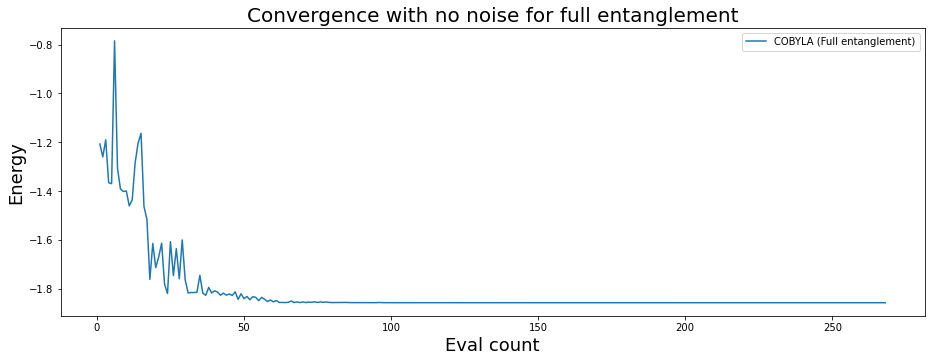

In [18]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_axes([1,1,1,1])

ax.plot(counts_cobyla_full, values_cobyla_full,label='COBYLA (Full entanglement)')


ax.set_xlabel('Eval count', size=18)
ax.set_ylabel('Energy', size=18)
ax.legend()
#ax.set_xlim([0,100])

ax.set_title('Convergence with no noise for full entanglement', size=20)

### &#128211; Plot the difference in energy from the reference value against each step of the optimization.  Put all this data into one or two plots

In [47]:
val_arr = np.array(values_cobyla) #Converting values_cobyla to a numpy array.

# It is much easier to manipulate numpy arrays than lists.

In [48]:
ref_value

-1.8572750815566401

In [49]:
#Modify the data you've gathered above using the reference value calculated with the NumpyMinimumEigenSolver()
#
#
# Your code goes here
#
#
diff_energy = [] #declaring an empty array that will store the energy differences.

diff_energy = ref_value - val_arr # the advantage of converting to numpy arrays = for loop is not required.

steps = np.arange(1,len(diff_energy)+1)


Text(0.5, 1.0, 'Energy Difference at each optimization step')

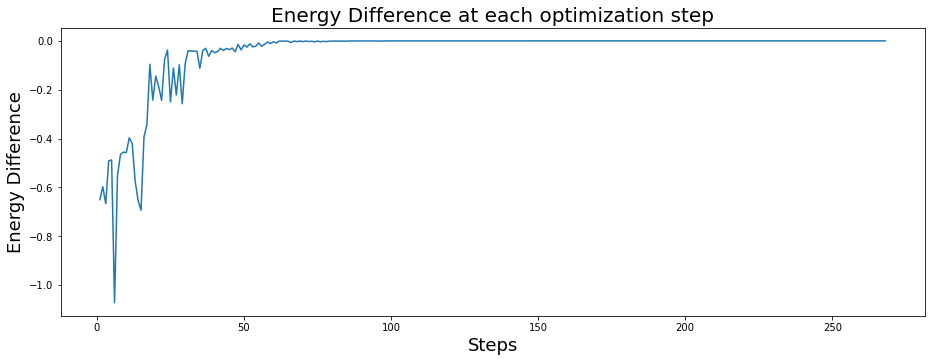

In [50]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_axes([1,1,1,1])
ax.plot(steps, diff_energy)
ax.set_xlabel('Steps', size=18)
ax.set_ylabel('Energy Difference', size=18)
ax.set_title('Energy Difference at each optimization step', size=20)

# &#128211; Plot the ground state energy of H2 as a function of interatomic distance

In [23]:
def H2_op_generator(dist):
    '''Function to generate H2 operators for given interatomic distances.
    INPUT: dist - interatomic distance coordinate.
    RETURN: The H2 operator for a given dist.'''
    
    qk_nature.settings.dict_aux_operators = True
    
    molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]])
    
    driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYQUANTE)
    
    #This prepares the second quantized fermionic operator after computing the one and two body orbitals
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    
    qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    H2_op = qubit_converter.convert(second_q_op['ElectronicEnergy'])
    #print(H2_op)
    
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    H2_op = qubit_converter.convert(second_q_op['ElectronicEnergy'], num_particles=es_problem.num_particles)
    #print(H2_op)
    
    return H2_op
    
    

In [52]:
interatomic_dist = np.arange(0.1,3.2,0.1) # range of interatomic distances
H2_op_arr = [] # array to store H2_op for a given interatomic distance.

for i in interatomic_dist:
    H2_op = H2_op_generator(i) # calling the H2_op_generator function for a given distance i.
    H2_op_arr.append(H2_op)

In [53]:
seed = 170
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

energy = [] # array to store all energy values for a given H2_op.
for op in range(len(H2_op_arr)):
    
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        
    ansatz = EfficientSU2(num_qubits=4, entanglement='linear')
    psa = SPSA(maxiter=iterations)
    vqe = VQE(ansatz, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=qi)
    
    result = vqe.compute_minimum_eigenvalue(operator=H2_op_arr[op])
    
    energy.append(values[-1]) # append the ground state energy from various H2_op to the energy array.

Text(0.5, 1.0, 'Energy at various interatomic distances')

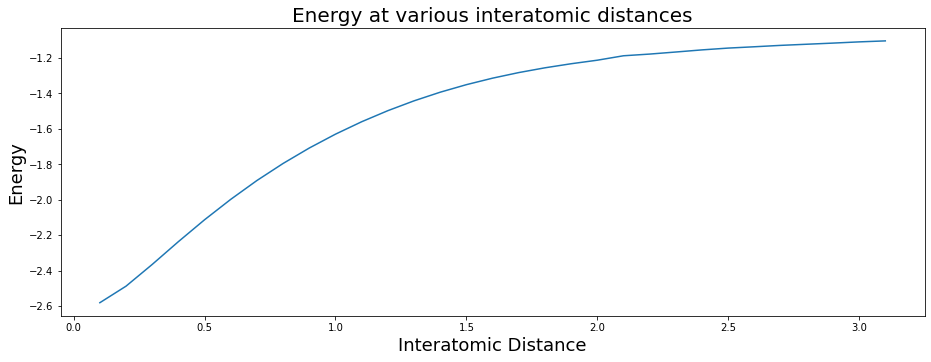

In [29]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_axes([1,1,1,1])
ax.plot(interatomic_dist, energy)
ax.set_xlabel('Interatomic Distance', size=18)
ax.set_ylabel('Energy', size=18)
ax.set_title('Energy at various interatomic distances', size=20)

# &#128211; Pick your favorite simple Hamiltonian of Pauli Operators (Heisenberg, Ising, Tight Binding, etc.).  Use VQE to find the ground state energy

### Use the opflow module of qiskit to create the operator.  You can find the tutorial [here](https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html).

In [30]:
#Compare the VQE result with the exact eigenvalue using the NumpyMinimumEigenSolver().  I'd recommend keeping
#  the total size of the operators to be < 5 qubits.  You should just need the Pauli ops imported below.
#
from qiskit.opflow import I, X, Y, Z
#
# Your code goes here
#
#
def H_ising(J: float, g: float):
    '''Function to give an Ising model (nearest neighbors) Hamiltonian for three qubits
    INPUTS: J: spin interaction; g: measure of response to external field.
    RETURNS: the desired Hamiltonian'''
    
    ZZs = (Z^Z^I) + (I^Z^Z)
    Xs = (X^I^I) + (I^X^I) + (I^I^X)
    
    H = -J*(ZZs + (g*Xs))
    return H

In [31]:
H_Ising = H_ising(1.,1.)

In [32]:
seed = 170
iterations = 300
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)



counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


    
ansatz_linear = EfficientSU2(num_qubits=4, entanglement='linear')
cobyla = COBYLA(maxiter=iterations)

vqe_linear = VQE(ansatz_linear, optimizer=cobyla, callback=store_intermediate_result, quantum_instance=qi)



result_linear = vqe_linear.compute_minimum_eigenvalue(operator=H_Ising)

In [45]:
npme = NumPyMinimumEigensolver()
result_npme = npme.compute_minimum_eigenvalue(operator=H_Ising)
ref_value_new = result_npme.eigenvalue.real
print(f'VQE on Aer qasm simulator (no noise): {result_linear.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result_linear.eigenvalue.real - ref_value_new):.5f}')


VQE on Aer qasm simulator (no noise): -3.47299
Delta from reference energy value is 0.02097


Text(0.5, 1.0, 'Convergence with no noise')

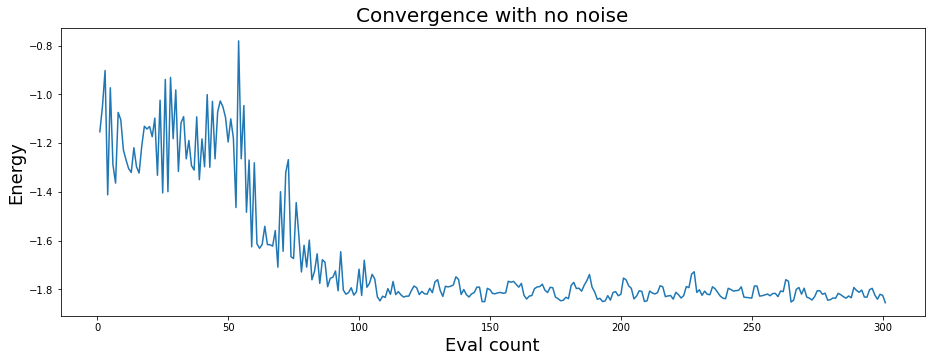

In [46]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_axes([1,1,1,1])

ax.plot(counts, values)

ax.set_xlabel('Eval count', size=18)
ax.set_ylabel('Energy', size=18)
ax.set_title('Convergence with no noise', size=20)